In [6]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [7]:
training = pd.read_csv('training.csv')
testing = pd.read_csv('test.csv')
# input -1 for missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)

# This code was removing column names, my changes rename the columns so they keep original values now
# Convert back to dataframe and replace the missing values
training = pd.DataFrame(imputer.fit_transform(training), columns=training.columns)

y_training = training.loc[:, :"mouth_center_bottom_lip_y"]


# Get the last feature column
lastFeature = training.iloc[:, -1]

# Split the last feature by spaces
splitFeatures = lastFeature.str.split(' ', expand=True)

# Drop the original last feature and concatenate the new split features
training = pd.concat([training.drop(training.columns[-1], axis=1), splitFeatures], axis=1)


# I drop the first columns here so they aren't mislabeled, and this way we can just make this the X_train
training.drop(training.columns[range(0, 30)], axis=1, inplace=True)


# This was renaming all target columns to pixel_i as well--code added before getting the last feature column fixes this
# Rename the columns to pixel_i
training.columns = [f'pixel_{i}' for i in range(training.shape[1])]


# Same for testing
testImg = testing.iloc[:, -1]
splitTest = testImg.str.split(' ', expand=True)
testing = pd.concat([testing.drop(testing.columns[-1], axis=1), splitTest], axis=1)

# there was an extra column that was just the index
testing.drop(columns=testing.columns[[0]], inplace=True)

# Rename the columns to pixel_i
testing.columns = ['ImageId'] + [f'pixel_{i}' for i in range(1, testing.shape[1])]

In [8]:
# Need to split data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(training, y_training, train_size=0.8, test_size=0.2, random_state=10)

In [9]:
# Reshape dataframe into numpy array so I can reshape it again
X_train = X_train.to_numpy(dtype=np.float32)

# Reshape image data so the model can process it as a Tensor
X_train = X_train.reshape(5639, 96, 96, 1)
X_train = X_train / 255.0

# Reshape y_train into a numpy array as well
y_train = np.array(y_train, dtype=np.float32)

# Reshape test data
X_test = X_test.to_numpy(dtype=np.float32)
X_test = X_test.reshape(1410, 96, 96, 1)
X_test = X_test / 255.0

y_test = np.array(y_test, dtype=np.float32)

In [10]:
# training some basic convolutional models based off of our homework
# this has to be a regression model (given that target outputs are floats) so it needs to be a little different

model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(26, (3,3), activation='relu', input_shape=(96, 96, 1)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(30)
])
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='mean_squared_error', metrics=['mean_squared_error'])
model.fit(X_train, y_train, epochs=10, batch_size=32)

/home/jaxtone/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - loss: 1309.1641 - mean_squared_error: 1309.1641
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - loss: 944.8682 - mean_squared_error: 944.8682
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - loss: 492.3374 - mean_squared_error: 492.3374
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - loss: 212.9105 - mean_squared_error: 212.9105
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - loss: 114.1445 - mean_squared_error: 114.1445
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - loss: 78.9247 - mean_squared_error: 78.9247
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - loss: 64.5658 - mean_squared_error: 64.5658
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - loss: 49.9081 - mean_squared_error: 49.9081
Epoch 9/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - loss: 47.5429 - mean_squared_error: 47.5429
Epoch 10/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - loss: 43.5155 - mean_

In [11]:
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Mean Squared Error (MSE): 238.87118530273438


In [ ]:
# Takes about 13 minutes to train

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(30)
])

model2.compile(optimizer='adam', loss='mean_squared_error')

model2.fit(X_train, y_train, epochs=30, batch_size=24, validation_split=0.2)

/home/jaxtone/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 148ms/step - loss: 1171.2310 - mean_squared_error: 1171.2310 - val_loss: 917.0764 - val_mean_squared_error: 917.0764
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - loss: 279.5966 - mean_squared_error: 279.5966 - val_loss: 436.2640 - val_mean_squared_error: 436.2640
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - loss: 154.7274 - mean_squared_error: 154.7274 - val_loss: 262.2399 - val_mean_squared_error: 262.2399
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - loss: 130.7650 - mean_squared_error: 130.7650 - val_loss: 139.2844 - val_mean_squared_error: 139.2844
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - loss: 100.3373 - mean_squared_error: 100.3373 - val_loss: 180.0067 - val_mean_squared_error: 180.0067
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - loss: 82.1055 - mean_squared_error: 82.1055 - val_loss: 158.3411 - val_mean_squared_error: 158.3411
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 14

In [13]:
y_pred = model2.predict(X_test)

mse2 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse2}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Mean Squared Error (MSE): 133.30426025390625


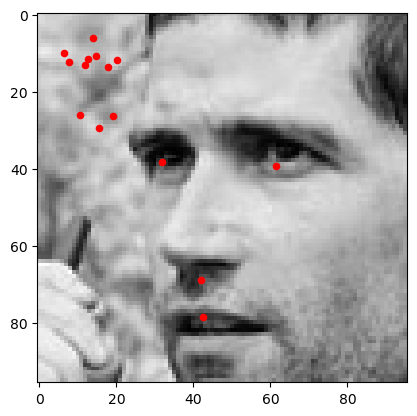

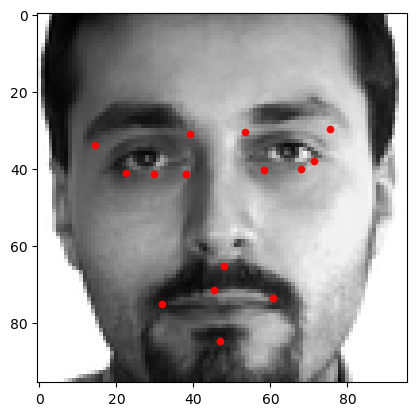

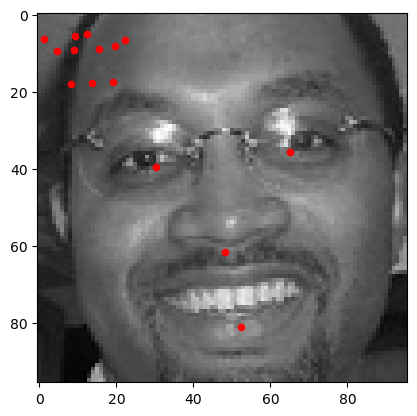

In [ ]:
import matplotlib.pyplot as plt

def showPrediction(image, keypoints): # Shows the image with the predicted keypoints
    plt.imshow(image, cmap='gray')
    for i in range(0, len(keypoints), 2):
        plt.scatter(keypoints[i], keypoints[i+1], c='red', s=20)
    plt.show()


for idx in range(20, 23):
    showPrediction(X_test[idx], y_pred[idx])